# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 06.10.2021

Мягкий дедлайн: 23:59MSK 25.10.2021

Жесткий дедлайн: 23:59MSK 28.10.2021

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import random

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2021-10-26 16:54:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  54.5MB/s    in 4.1s    

2021-10-26 16:54:47 (49.3 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.6

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [ ]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
0,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,73.04667,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,202.18689,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,13.09302,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,-0.01744,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,28.68782,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,

In [ ]:
print('Train size:', X_train.shape)
print('Test size:', X_test.shape)

Train size: (463715, 90)
Test size: (51630, 90)


## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
simple_pipeline = Pipeline([
    ('transformer', StandardScaler()),
    ('ridge_reg', Ridge())
])

simple_model = simple_pipeline.fit(X_train, y_train)

y_pred_train_ridge = simple_model.predict(X_train)
y_pred_test_ridge = simple_model.predict(X_test)

print('Train RMSE: %.5f' % mean_squared_error(y_train, y_pred_train_ridge, squared=False))
print('Test RMSE: %.5f' % mean_squared_error(y_test, y_pred_test_ridge, squared=False))

Train RMSE: 9.55282
Test RMSE: 9.51016


Выше представлен результат работы обычной Ridge-регресси.

Как известно, наилучшей константной моделью является среднее значение таргета, посмотрим на результат такой модели:

In [ ]:
const_pred = y_train.mean()

y_const_pred_train = np.full(X_train.shape[0], const_pred)
y_const_pred_test = np.full(X_test.shape[0], const_pred)

print('Train RMSE: %.5f' % mean_squared_error(y_train, y_const_pred_train, squared=False))
print('Test RMSE: %.5f' % mean_squared_error(y_test, y_const_pred_test, squared=False))

Train RMSE: 10.93976
Test RMSE: 10.85246


Выше представлен результат работы константной модели.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

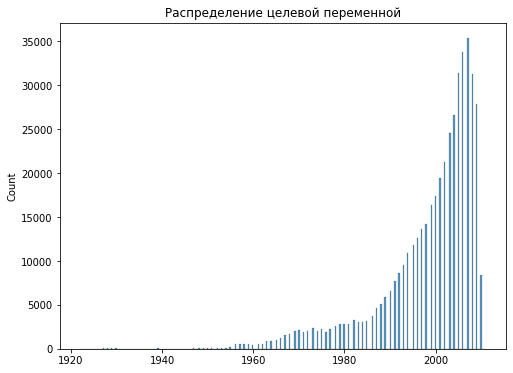

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.histplot(y_train)
plt.title('Распределение целевой переменной')
plt.show()

## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
!pip install wandb --upgrade --quiet
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
scaler_x = StandardScaler()
X_train_ss = scaler_x.fit_transform(X_train)
X_test_ss = scaler_x.transform(X_test)
x_scale = scaler_x.scale_

scaler_y = StandardScaler()
y_train_ss = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_ss = scaler_y.transform(y_test.reshape(-1, 1))
y_scale = scaler_y.scale_

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index):
        return torch.tensor(self.x[index], dtype=torch.float), torch.tensor(self.y[index], dtype=torch.float)

In [ ]:
batch_size = 2048
set_random_seed(123)

train_set = MyDataset(X_train_ss, y_train_ss)
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           shuffle=True)

test_set = MyDataset(X_test_ss, y_test_ss)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
def train(model, optimizer, criterion, n_epoch, train_loader, test_loader, y_scale, device):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        n_epoch - number of learning epochs
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    '''
    for epoch in range(n_epoch):
        # обучение
        model.train()
        for x_train, y_train in tqdm(iter(train_loader)):
            x_train = x_train.to(device)
            y_train = y_train.to(device)

            optimizer.zero_grad()
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            wandb.log({'train RMSE' : torch.sqrt(loss) * y_scale})
        
        # валидация
        test_loss = 0
        test_size = 0
        model.eval()
        with torch.no_grad():
            for x_test, y_test in iter(test_loader):
                x_test = x_test.to(device)
                y_test = y_test.to(device)

                y_pred = model(x_test)
                loss = criterion(y_pred, y_test)
                test_loss += loss.item() * y_pred.size(0)
                test_size += y_pred.size(0)
            
        # вывод метрик
        print(f'Epoch: {epoch}, RMSE: {torch.sqrt(torch.tensor(test_loss / test_size)) * y_scale}')
        wandb.log({'test RMSE' : torch.sqrt(torch.tensor(test_loss / test_size)) * y_scale})

In [ ]:
def test(model, test_loader, device):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    predicts = []
    with torch.no_grad():
        model.eval()
        for x_test, y_test in iter(test_loader):
            x_test = x_test.to(device)
            y_test = y_test.to(device)

            y_pred = model(x_test)
            predicts.extend(y_pred)
    return torch.tensor(predicts)

## Первый этап работы:

Для начала я попробовала обучить элементарнейшую модель с одинм слоем (по сути это просто линейная модель и она должна выдавать результат хотя бы как Ridge).

На этой модели я отлаживала мои функции, написанные выше и проверяла работоспособность всего кода.

In [ ]:
set_random_seed(123)
model = nn.Sequential(
    nn.Linear(90, 1)
)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

wandb.init(project='homework_1',
           name = 'simple linear model',
           config={'epochs' : 30,
                   'batch_size' : 2048,
                   'model' : model,
                   'optimizer' : optimizer
    })
wandb.watch(model);
train(model, optimizer, criterion, 30, train_loader, test_loader, y_scale[0], device)

test RMSE,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train RMSE,█▄▄▁▂▃▂▁▃▃▃▄▃▄▃▄▂▂▃▄▃▂▂▃▃▂▃▂▃▃▄▅▂▄▄▃▁▃▃▃
test RMSE,9.51973
train RMSE,8.90932


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 0, RMSE: 9.820585250854492


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 1, RMSE: 9.614075660705566


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 2, RMSE: 9.548357009887695


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 3, RMSE: 9.525447845458984


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 4, RMSE: 9.515528678894043


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 5, RMSE: 9.514201164245605


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 6, RMSE: 9.513506889343262


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 7, RMSE: 9.51284122467041


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 8, RMSE: 9.511435508728027


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 9, RMSE: 9.514425277709961


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 10, RMSE: 9.516387939453125


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 11, RMSE: 9.519651412963867


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 12, RMSE: 9.510418891906738


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 13, RMSE: 9.50879192352295


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 14, RMSE: 9.516642570495605


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 15, RMSE: 9.525503158569336


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 16, RMSE: 9.522528648376465


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 17, RMSE: 9.512240409851074


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 18, RMSE: 9.516515731811523


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 19, RMSE: 9.515376091003418


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 20, RMSE: 9.517183303833008


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 21, RMSE: 9.509696960449219


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 22, RMSE: 9.514827728271484


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 23, RMSE: 9.512983322143555


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 24, RMSE: 9.517090797424316


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 25, RMSE: 9.515804290771484


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 26, RMSE: 9.517181396484375


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 27, RMSE: 9.517373085021973


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 28, RMSE: 9.518702507019043


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 29, RMSE: 9.519728660583496


Проверю с помощью ассерта, предложенного в шаблоне данного дз, правильность функции test:

In [ ]:
assert test(model, test_loader, device).shape[0] == y_test.shape[0]

Прилагаю график обучения с сайта wandb:

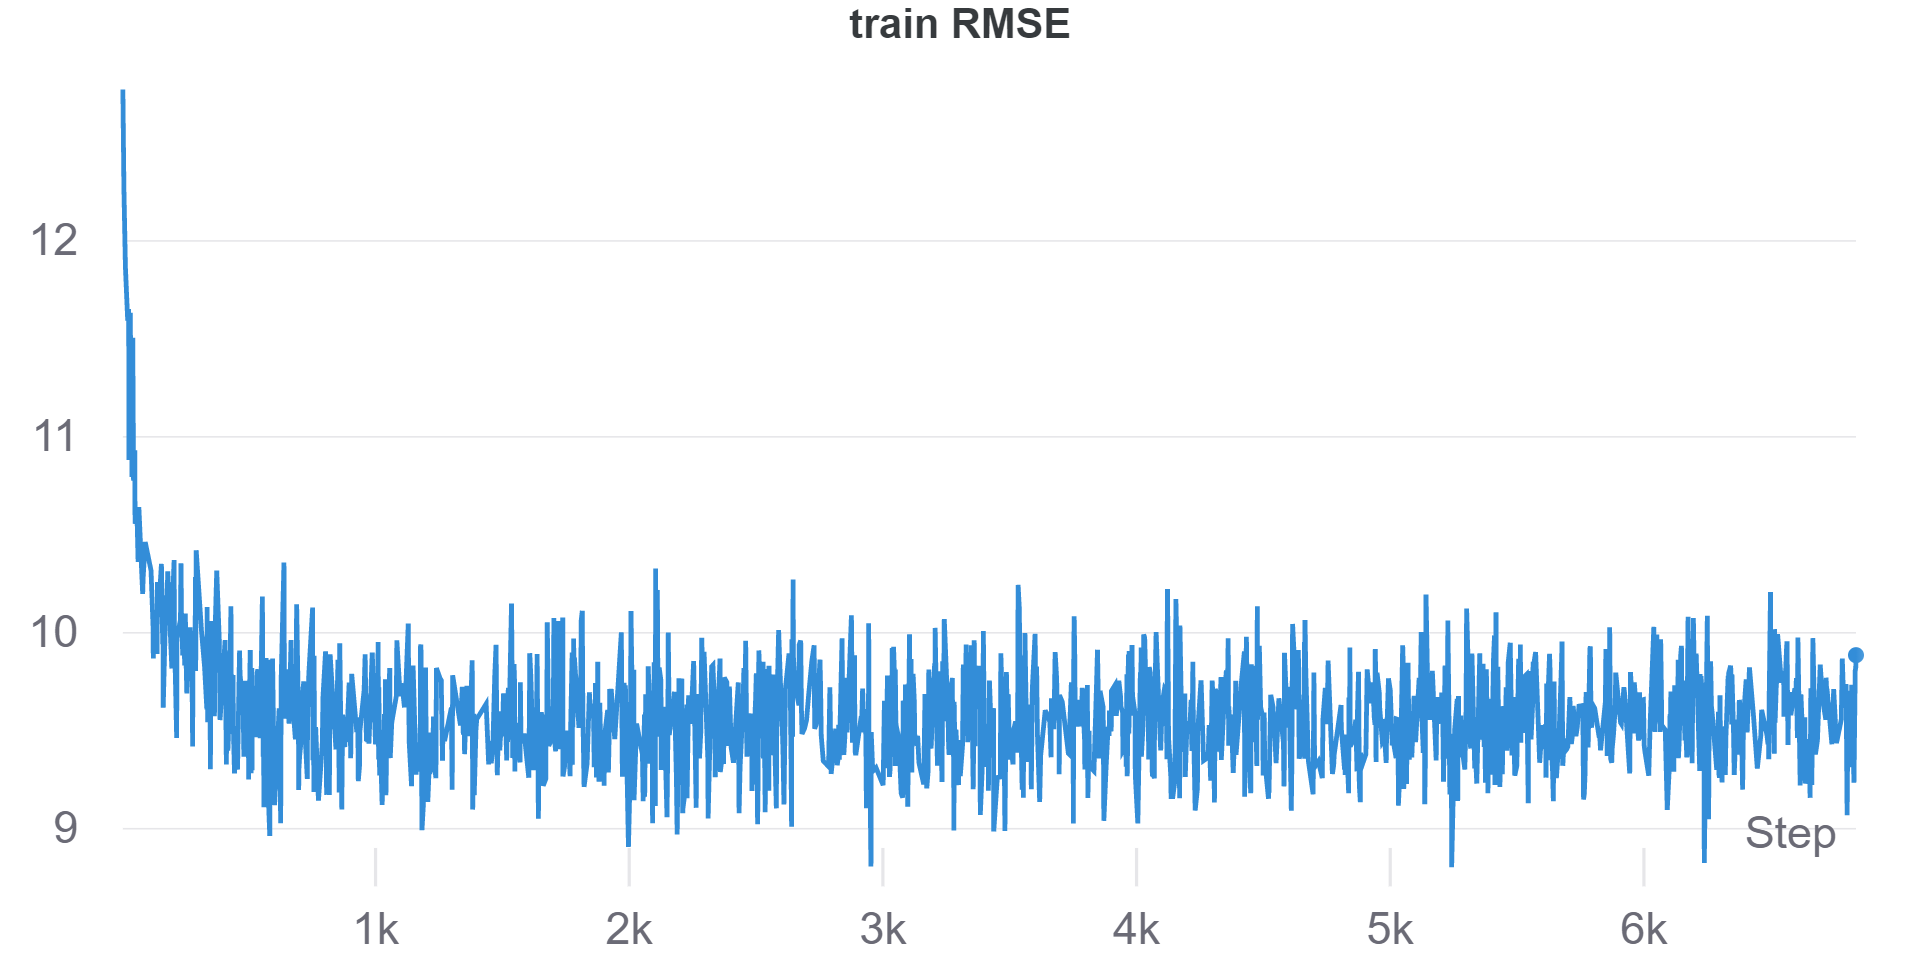

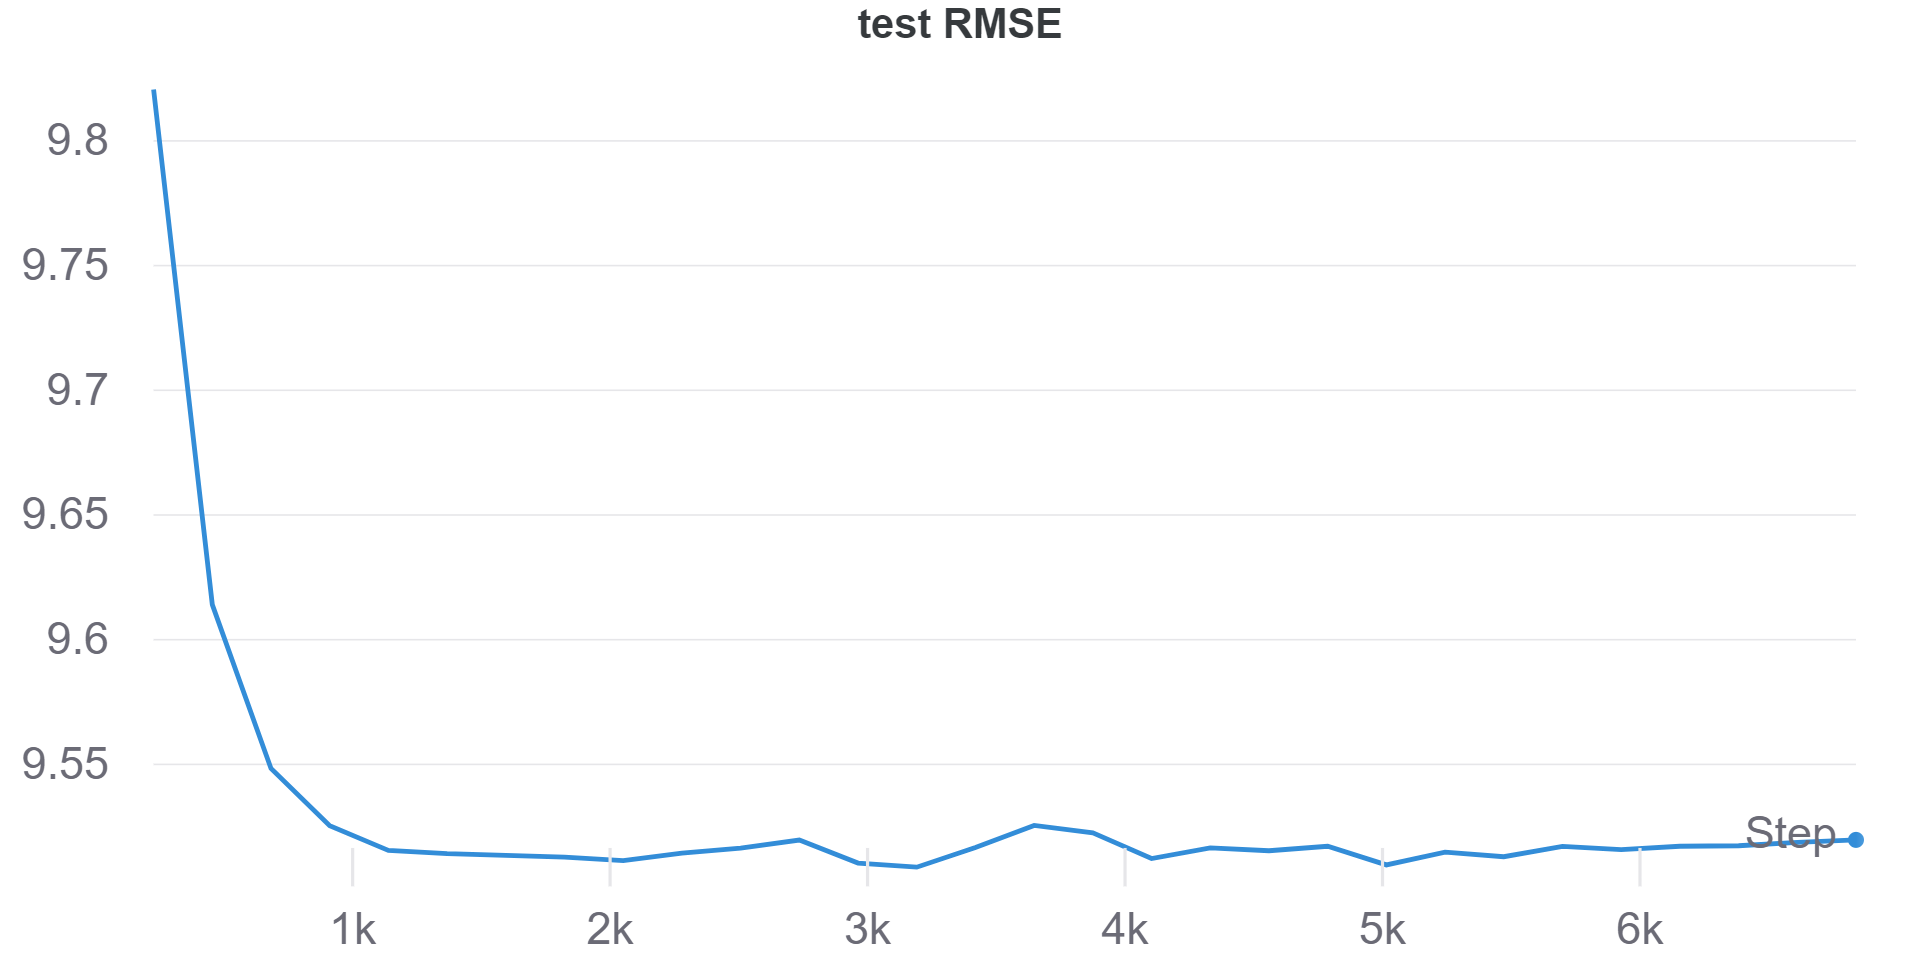

Итоговая ошибка на тесте:

In [ ]:
predictions = test(model, test_loader, device)
print(mean_squared_error(torch.tensor(y_test_ss), predictions, squared=False) * y_scale[0])

9.519728333406755


Получаю качество очень близкое к тому, что выдавал Ridge (как и ожидалось), все функции хорошо работают, можно переходить к более сложным моделям.

## Второй этап:

Пробую двухслойную сеть с небольшими слоями (всего 100 нейронов).

In [ ]:
set_random_seed(123)
model = nn.Sequential(
    nn.Linear(90, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

wandb.init(project='homework_1',
           name = 'first 2-layer model',
           config={'epochs' : 30,
                   'batch_size' : 2048,
                   'model' : model,
                   'optimizer' : optimizer
    })
wandb.watch(model);
train(model, optimizer, criterion, 30, train_loader, test_loader, y_scale[0], device)

test RMSE,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train RMSE,█▄▄▁▂▃▂▁▃▃▃▄▃▄▃▄▂▂▃▄▃▂▂▃▃▂▃▂▃▃▄▅▂▄▄▃▁▃▃▃
test RMSE,9.51973
train RMSE,8.90932


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 0, RMSE: 9.245621681213379


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 1, RMSE: 9.114047050476074


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 2, RMSE: 9.066407203674316


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 3, RMSE: 9.036735534667969


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 4, RMSE: 9.026938438415527


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 5, RMSE: 9.010672569274902


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 6, RMSE: 9.015188217163086


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 7, RMSE: 8.997076034545898


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 8, RMSE: 8.980259895324707


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 9, RMSE: 8.972294807434082


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 10, RMSE: 8.967988014221191


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 11, RMSE: 8.96658992767334


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 12, RMSE: 8.9569091796875


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 13, RMSE: 8.946684837341309


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 14, RMSE: 8.95119571685791


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 15, RMSE: 8.92750072479248


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 16, RMSE: 8.932572364807129


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 17, RMSE: 8.93413257598877


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 18, RMSE: 8.920398712158203


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 19, RMSE: 8.942570686340332


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 20, RMSE: 8.923603057861328


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 21, RMSE: 8.92500114440918


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 22, RMSE: 8.91345500946045


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 23, RMSE: 8.926961898803711


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 24, RMSE: 8.917564392089844


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 25, RMSE: 8.912758827209473


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 26, RMSE: 8.923920631408691


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 27, RMSE: 8.912842750549316


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 28, RMSE: 8.906367301940918


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 29, RMSE: 8.912833213806152


Прилагаю график обучения с сайта wandb:

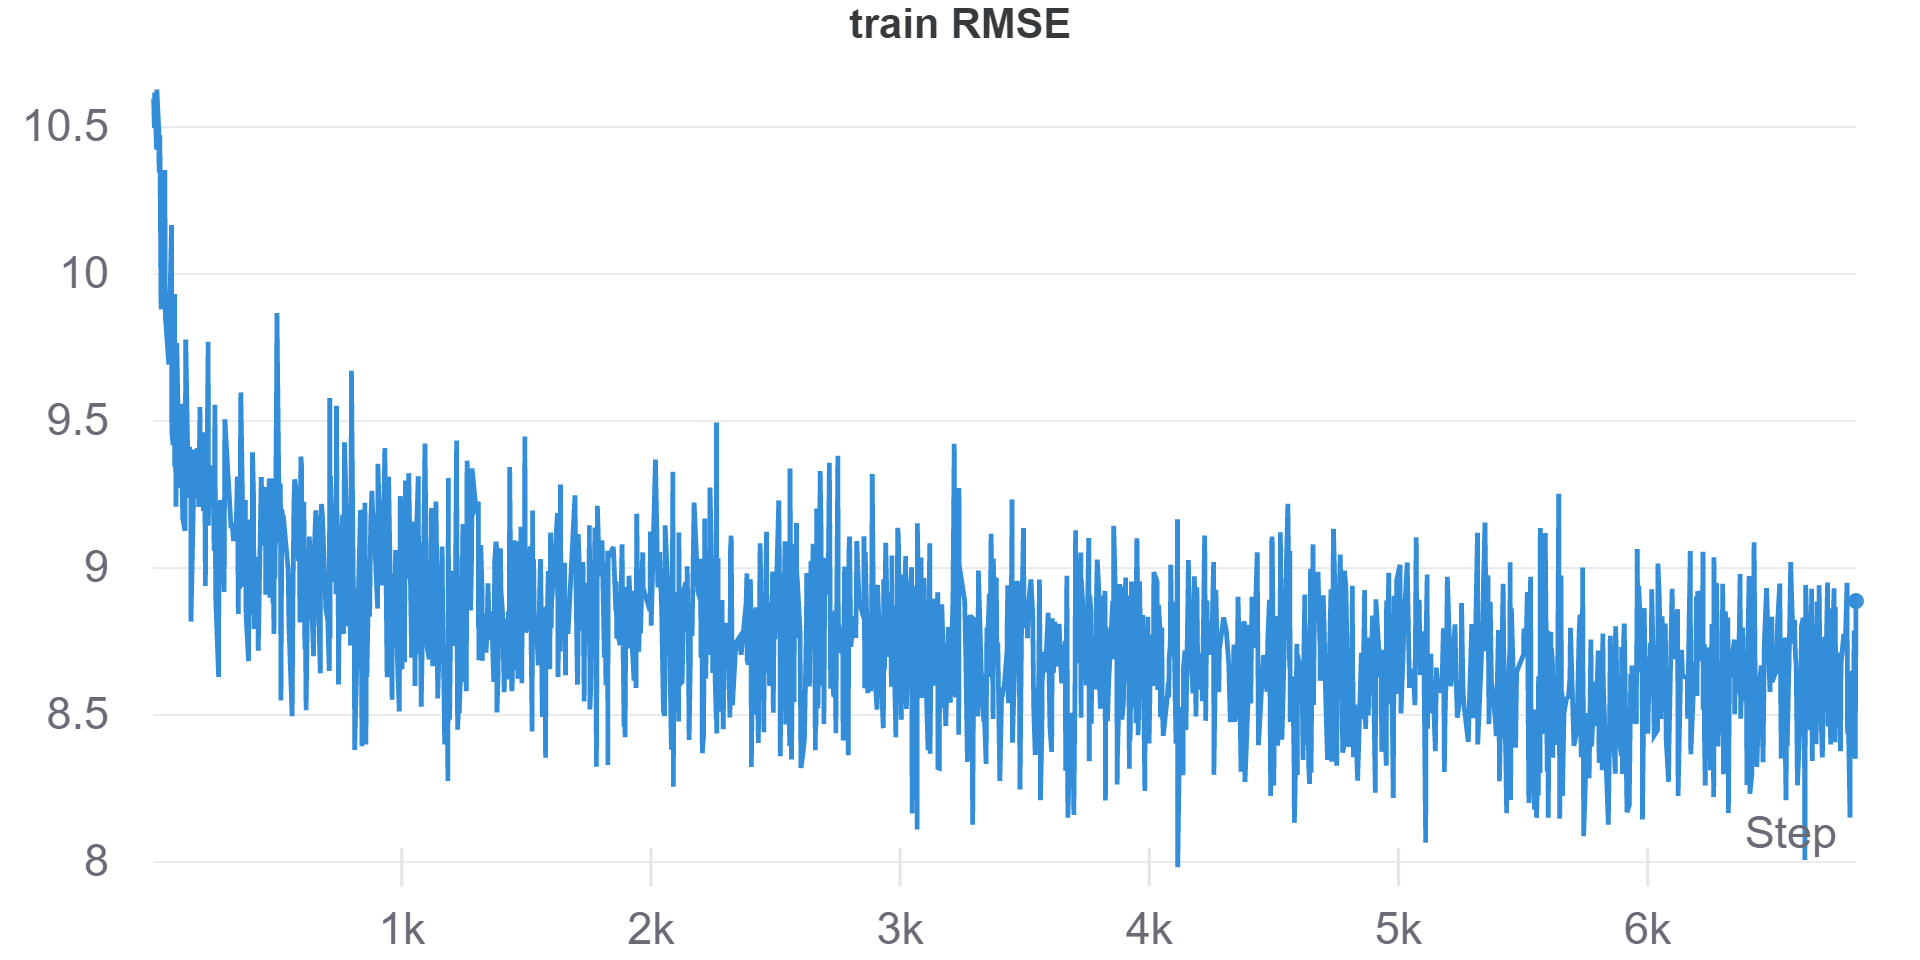

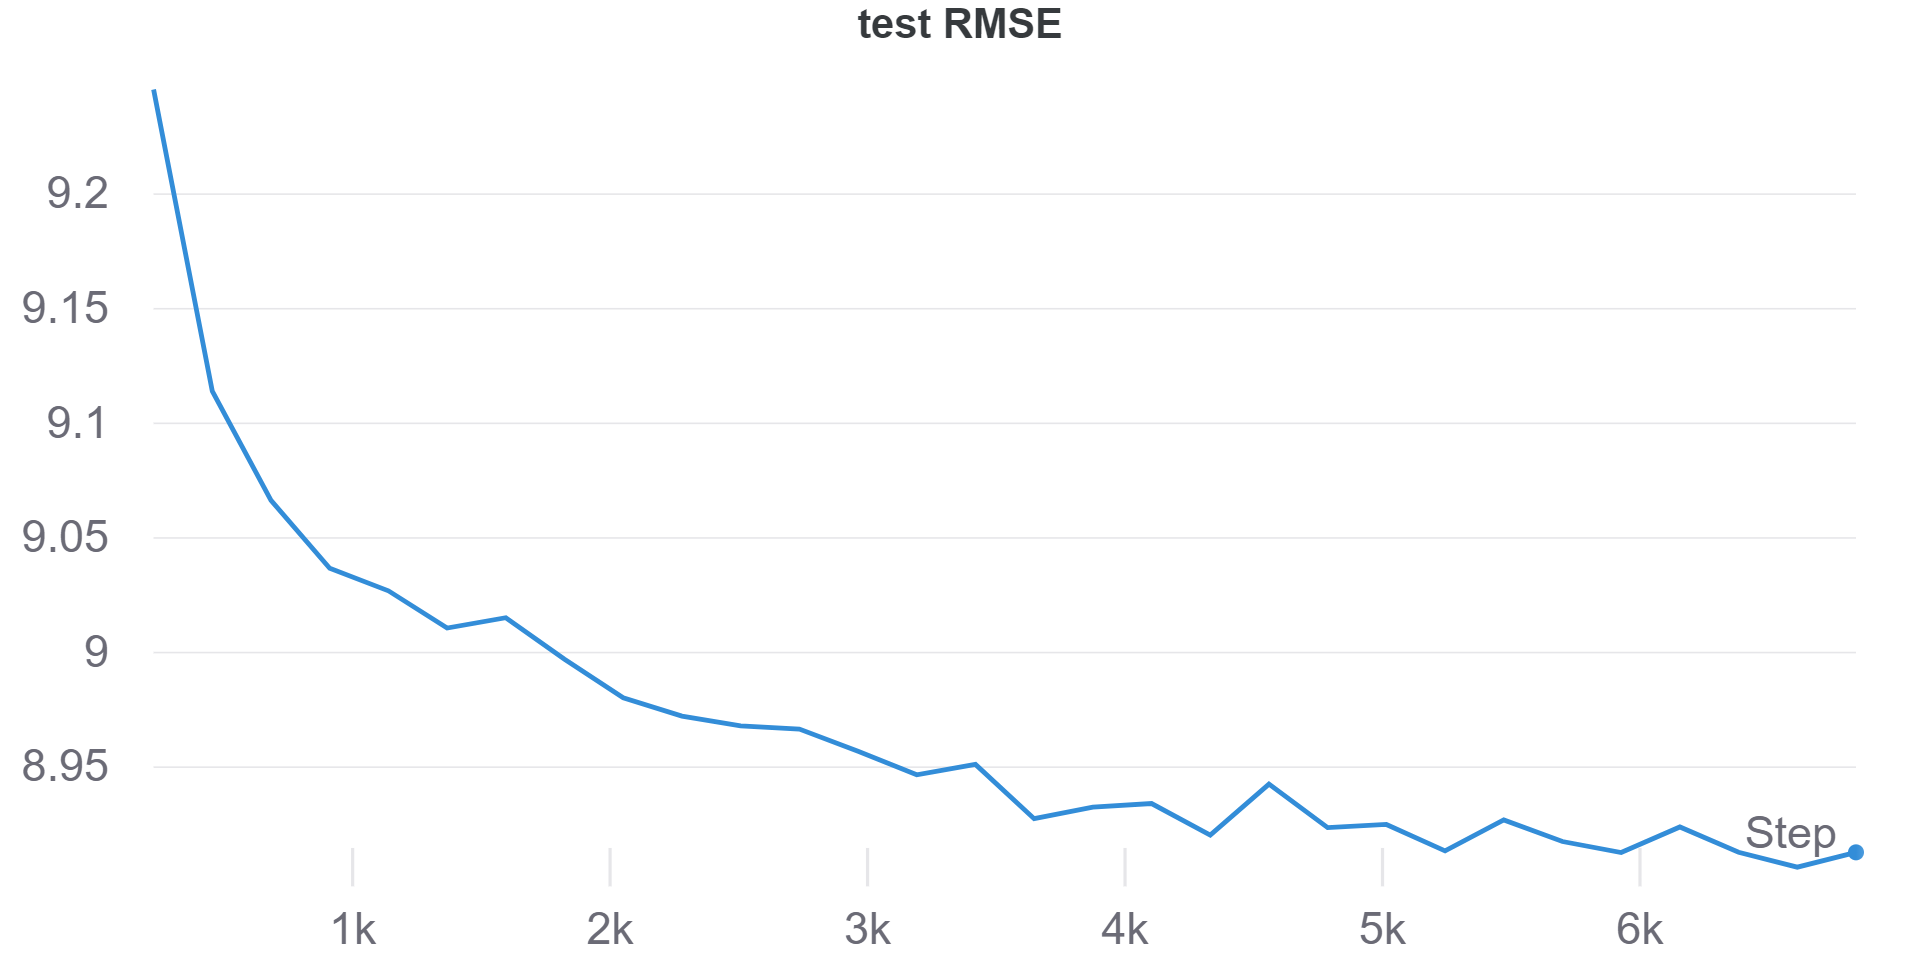

Посчитаю итоговую ошибку на тесте:

In [ ]:
predictions = test(model, test_loader, device)
print(mean_squared_error(torch.tensor(y_test_ss), predictions, squared=False) * y_scale[0])

8.912833168826785


Эта модель уже превосхожит по качеству обычную Ridge-регрессию.

## Третий этап:

Усложню модель, добавив третий полносвязный слой.

In [ ]:
set_random_seed(123)
model = nn.Sequential(
    nn.Linear(90, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

wandb.init(project='homework_1',
           name = 'first 3-layer model',
           config={'epochs' : 30,
                   'batch_size' : 2048,
                   'model' : model,
                   'optimizer' : optimizer
    })
wandb.watch(model);
train(model, optimizer, criterion, 30, train_loader, test_loader, y_scale[0], device)

test RMSE,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁
train RMSE,█▅▄▅▅▄▃▆▄▅▄▃▂▅▄▃▂▄▃▃▄▃▂▃▂▃▃▄▃▃▄▄▂▃▃▂▃▅▃▁
test RMSE,8.91283
train RMSE,9.02616


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 0, RMSE: 9.096020698547363


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 1, RMSE: 8.98340129852295


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 2, RMSE: 8.916728973388672


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 3, RMSE: 8.897555351257324


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 4, RMSE: 8.862140655517578


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 5, RMSE: 8.841306686401367


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 6, RMSE: 8.861637115478516


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 7, RMSE: 8.856132507324219


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 8, RMSE: 8.837981224060059


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 9, RMSE: 8.83719253540039


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 10, RMSE: 8.832335472106934


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 11, RMSE: 8.83570671081543


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 12, RMSE: 8.816414833068848


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 13, RMSE: 8.810930252075195


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 14, RMSE: 8.831430435180664


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 15, RMSE: 8.835688591003418


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 16, RMSE: 8.85583209991455


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 17, RMSE: 8.840554237365723


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 18, RMSE: 8.834748268127441


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 19, RMSE: 8.849735260009766


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 20, RMSE: 8.846539497375488


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 21, RMSE: 8.851642608642578


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 22, RMSE: 8.83823013305664


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 23, RMSE: 8.844415664672852


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 24, RMSE: 8.85561466217041


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 25, RMSE: 8.88515853881836


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 26, RMSE: 8.862797737121582


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 27, RMSE: 8.869235038757324


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 28, RMSE: 8.873090744018555


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 29, RMSE: 8.878536224365234


Прилагаю график обучения с сайта wandb:

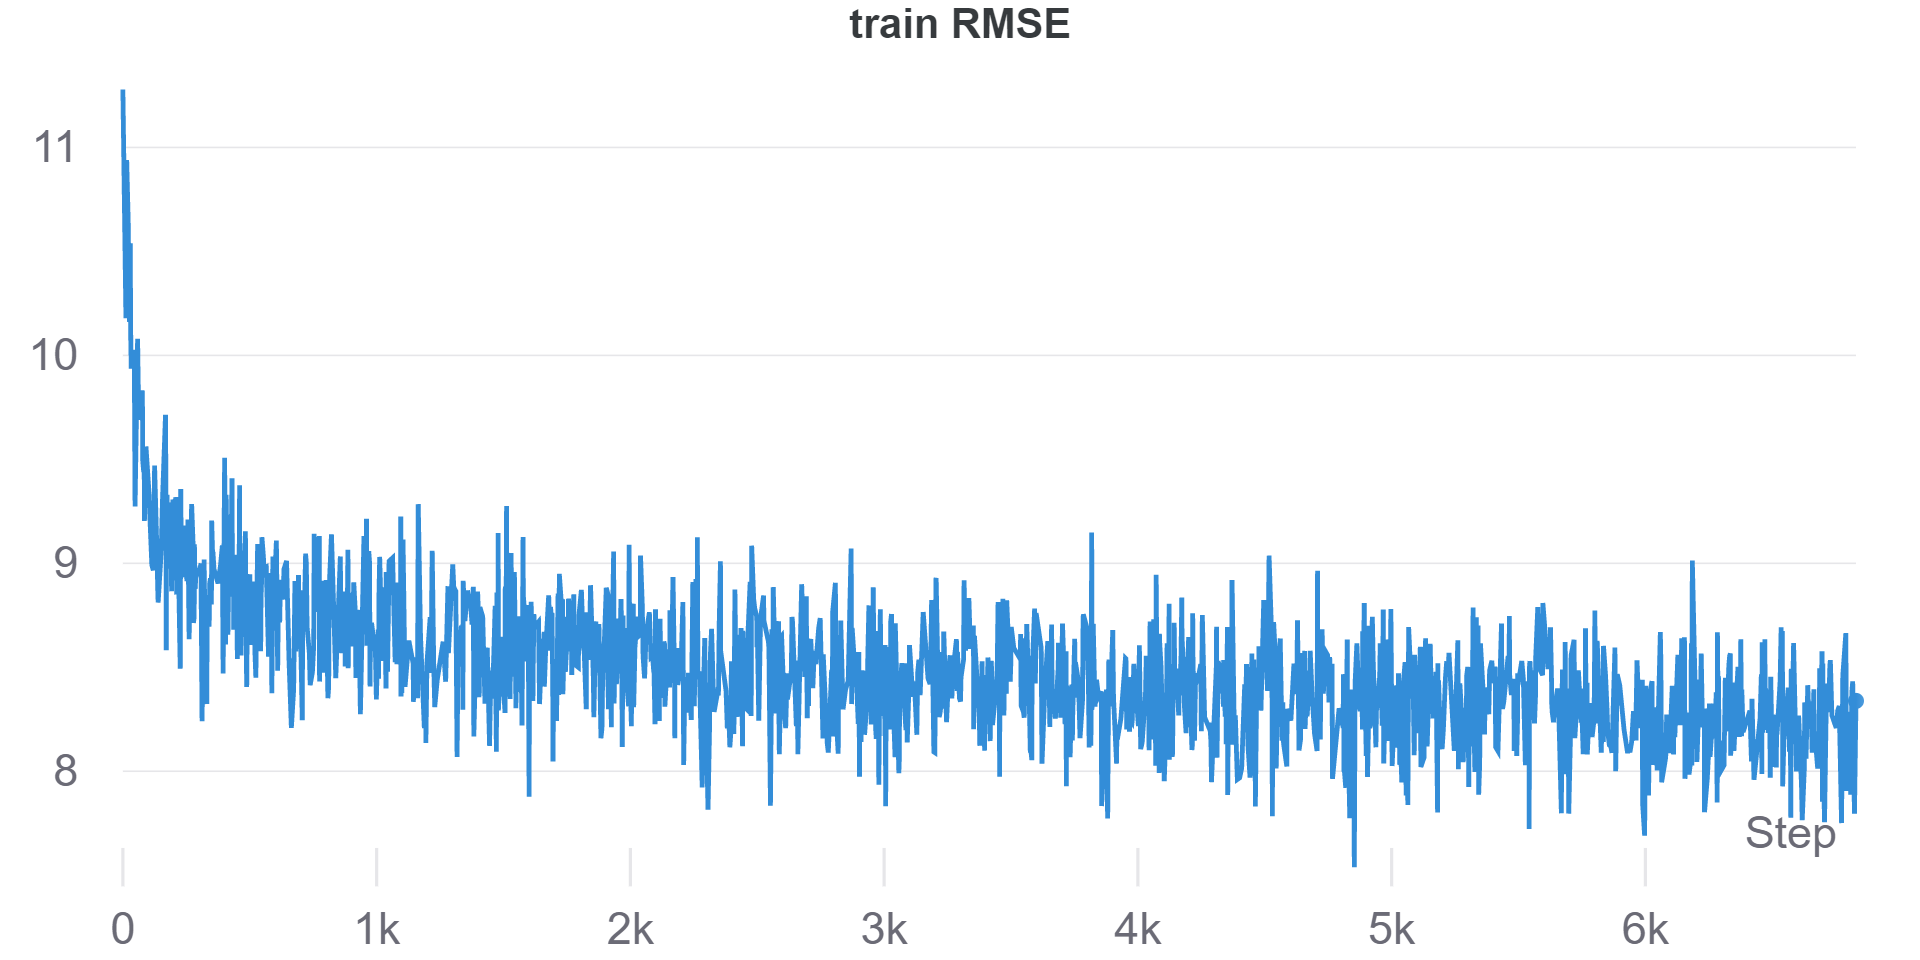

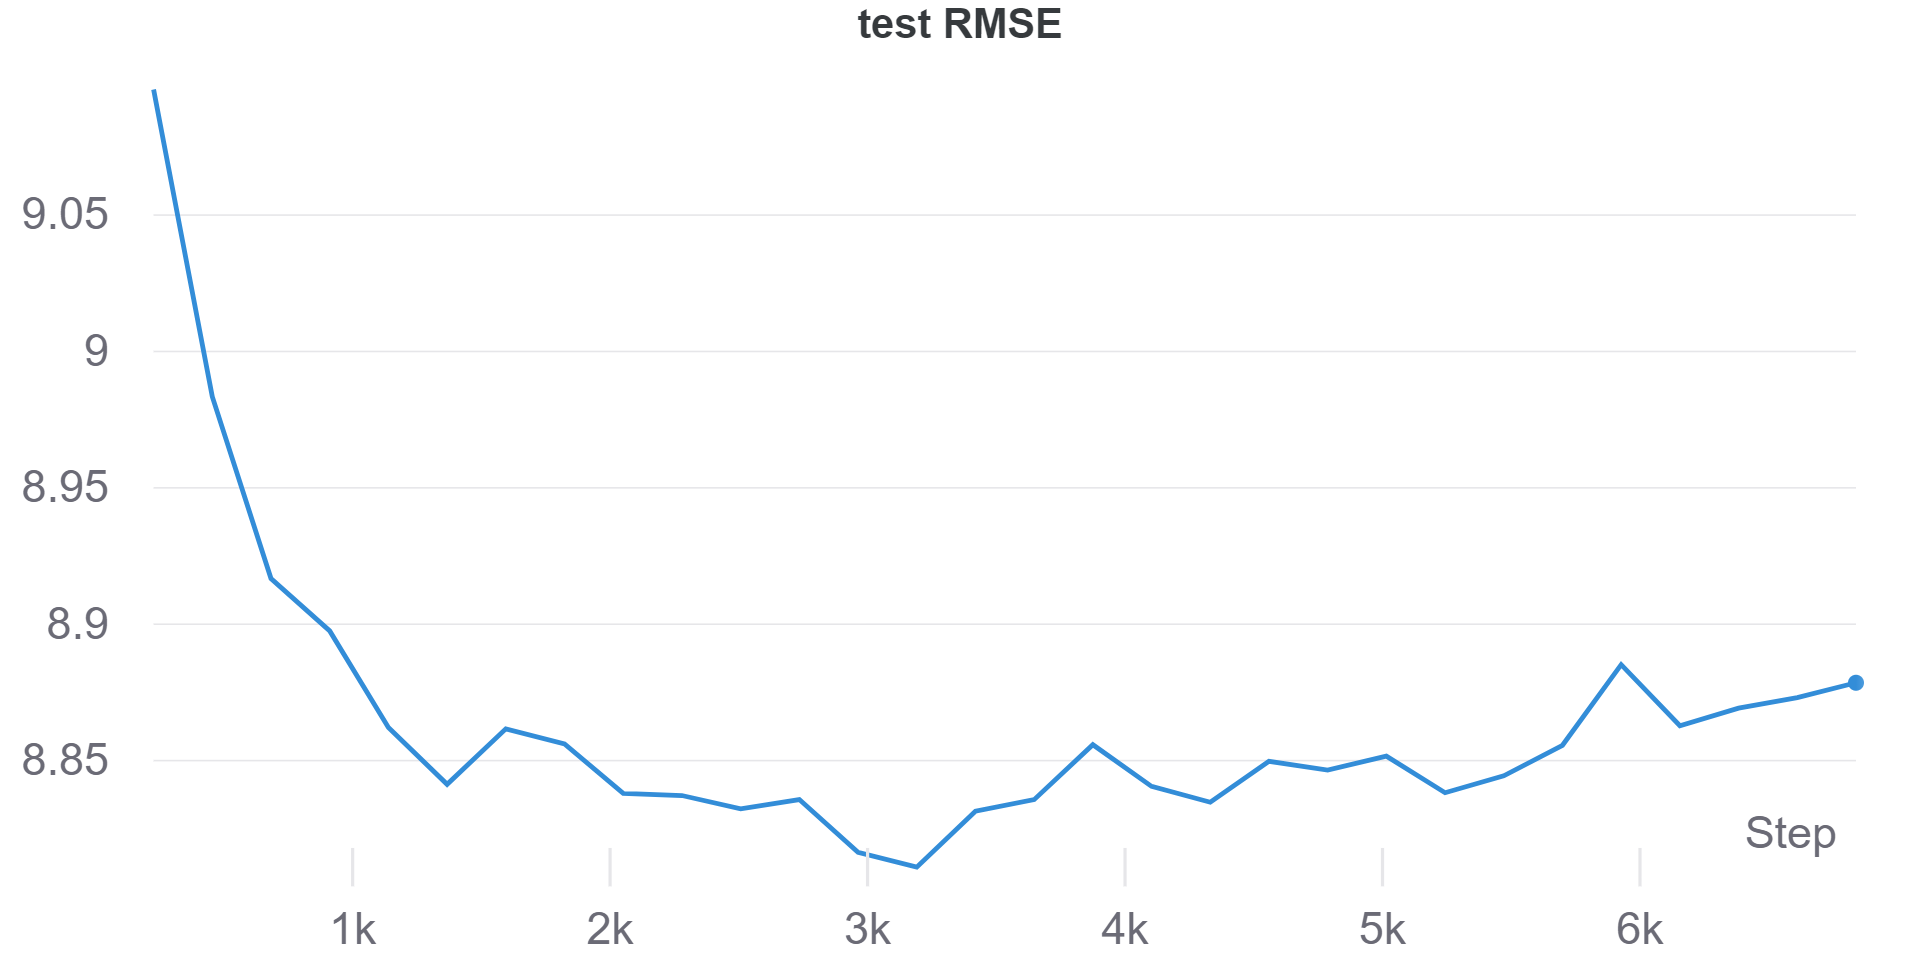

Посчитаю итоговую ошибку на тесте:

In [ ]:
predictions = test(model, test_loader, device)
print(mean_squared_error(torch.tensor(y_test_ss), predictions, squared=False) * y_scale[0])

8.878536170296295


Снова получаю улучшение в качестве!

Хотя данная модель и дала лучшее качество по сравнению с предыдущей моделью, тем не менее можно заметить, что на 12 - 13 эпохах ошибка была меньше, чем получилась в итоге. После 13 эпохи ошибка росла на тестовой выборке, хотя по графикам было видно, что на тестойо выборке ошибка убывала (при чём она не вышла на плато за 30 эпох, то есть могла убывать и дальше). Это означает, что модель с такой архитектурой переобучается.

## Четвёртый этап:

Возьму ту же модель, что и на третьем этапе, но добавлю туда один Dropout слой, чтобы исключить переубучение.

In [ ]:
set_random_seed(123)
model = nn.Sequential(
    nn.Linear(90, 100),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

wandb.init(project='homework_1',
           name = 'second 3-layer model',
           config={'epochs' : 30,
                   'batch_size' : 2048,
                   'model' : model,
                   'optimizer' : optimizer
    })
wandb.watch(model);
train(model, optimizer, criterion, 30, train_loader, test_loader, y_scale[0], device)

test RMSE,█▅▄▃▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▃▂▂▃▃
train RMSE,█▅▃▅▃▅▃▂▃▃▃▄▂▂▂▃▂▂▄▃▃▂▂▃▃▂▃▃▃▂▄▃▃▃▁▂▁▂▂▂
test RMSE,8.87854
train RMSE,8.54785


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 0, RMSE: 9.118375778198242


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 1, RMSE: 8.984603881835938


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 2, RMSE: 8.889545440673828


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 3, RMSE: 8.86518383026123


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 4, RMSE: 8.828851699829102


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 5, RMSE: 8.807061195373535


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 6, RMSE: 8.807382583618164


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 7, RMSE: 8.791099548339844


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 8, RMSE: 8.801386833190918


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 9, RMSE: 8.783787727355957


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 10, RMSE: 8.784627914428711


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 11, RMSE: 8.781181335449219


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 12, RMSE: 8.755987167358398


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 13, RMSE: 8.75587272644043


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 14, RMSE: 8.768448829650879


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 15, RMSE: 8.755911827087402


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 16, RMSE: 8.752996444702148


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 17, RMSE: 8.750609397888184


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 18, RMSE: 8.74828052520752


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 19, RMSE: 8.738604545593262


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 20, RMSE: 8.745475769042969


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 21, RMSE: 8.740134239196777


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 22, RMSE: 8.738015174865723


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 23, RMSE: 8.742512702941895


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 24, RMSE: 8.728976249694824


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 25, RMSE: 8.742874145507812


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 26, RMSE: 8.74535083770752


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 27, RMSE: 8.746917724609375


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 28, RMSE: 8.73435115814209


  0%|          | 0/227 [00:00<?, ?it/s]

Epoch: 29, RMSE: 8.734758377075195


Прилагаю график обучения с сайта wandb:

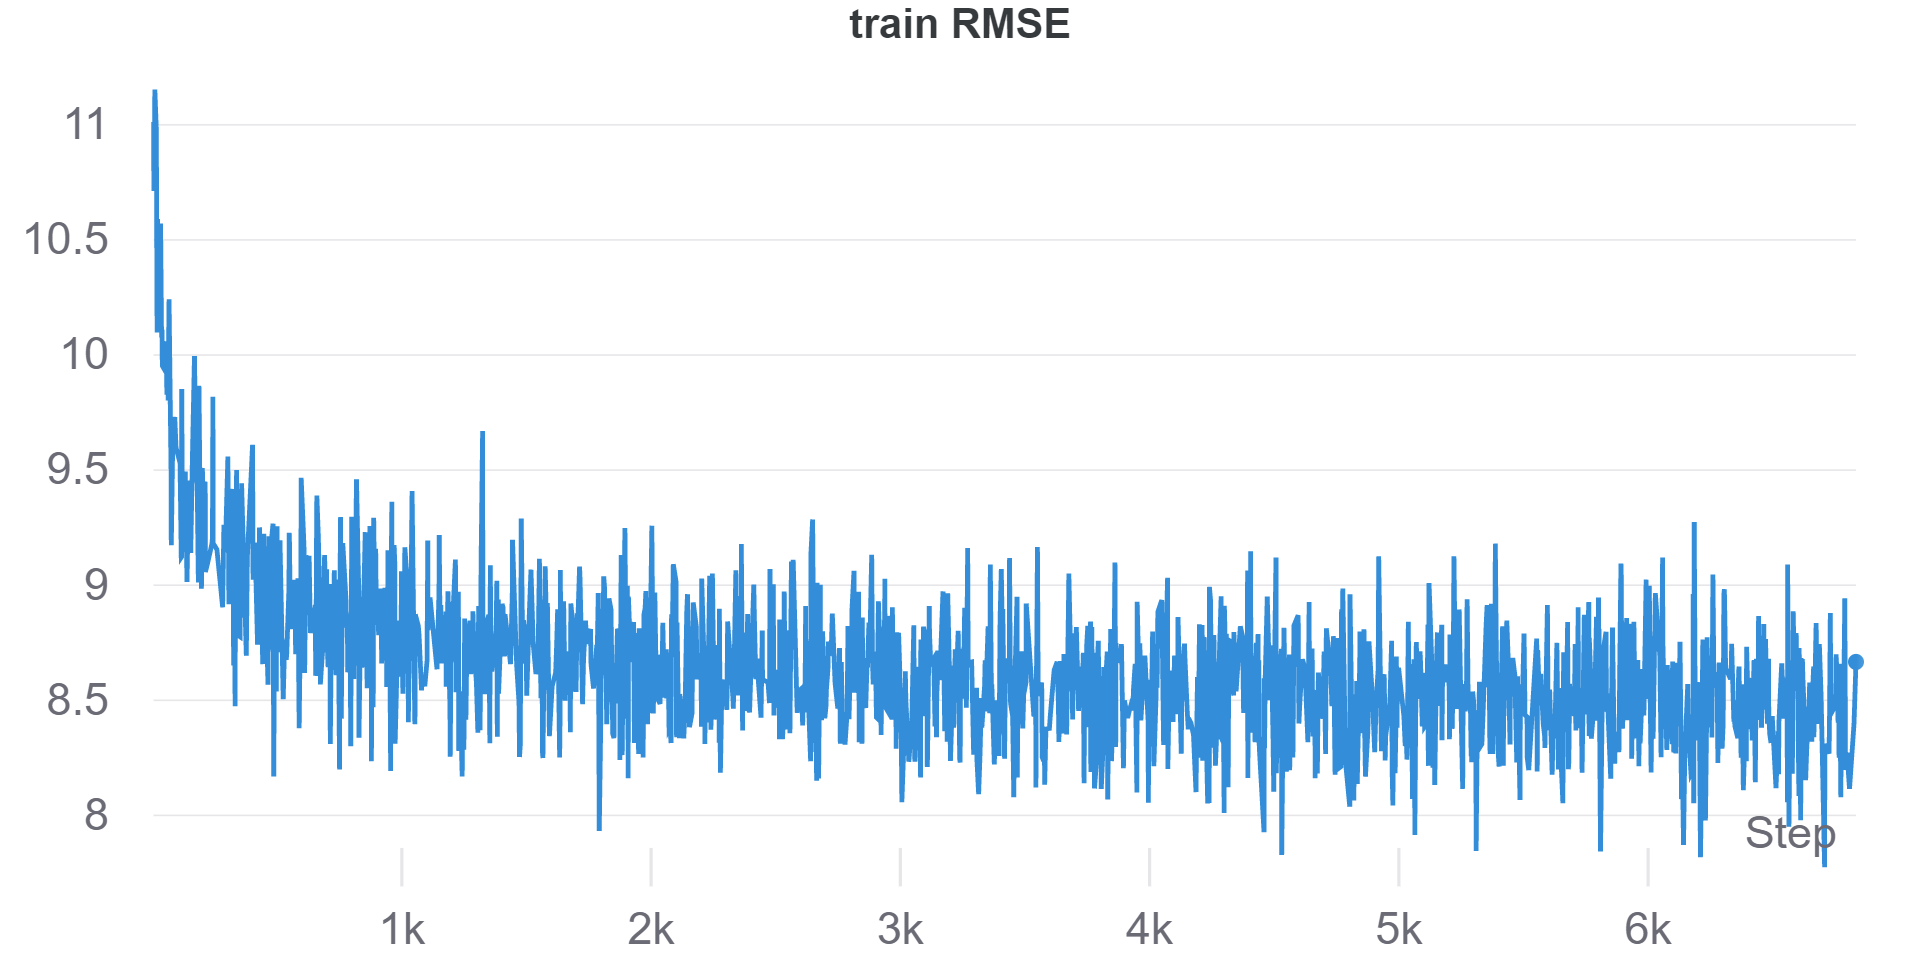

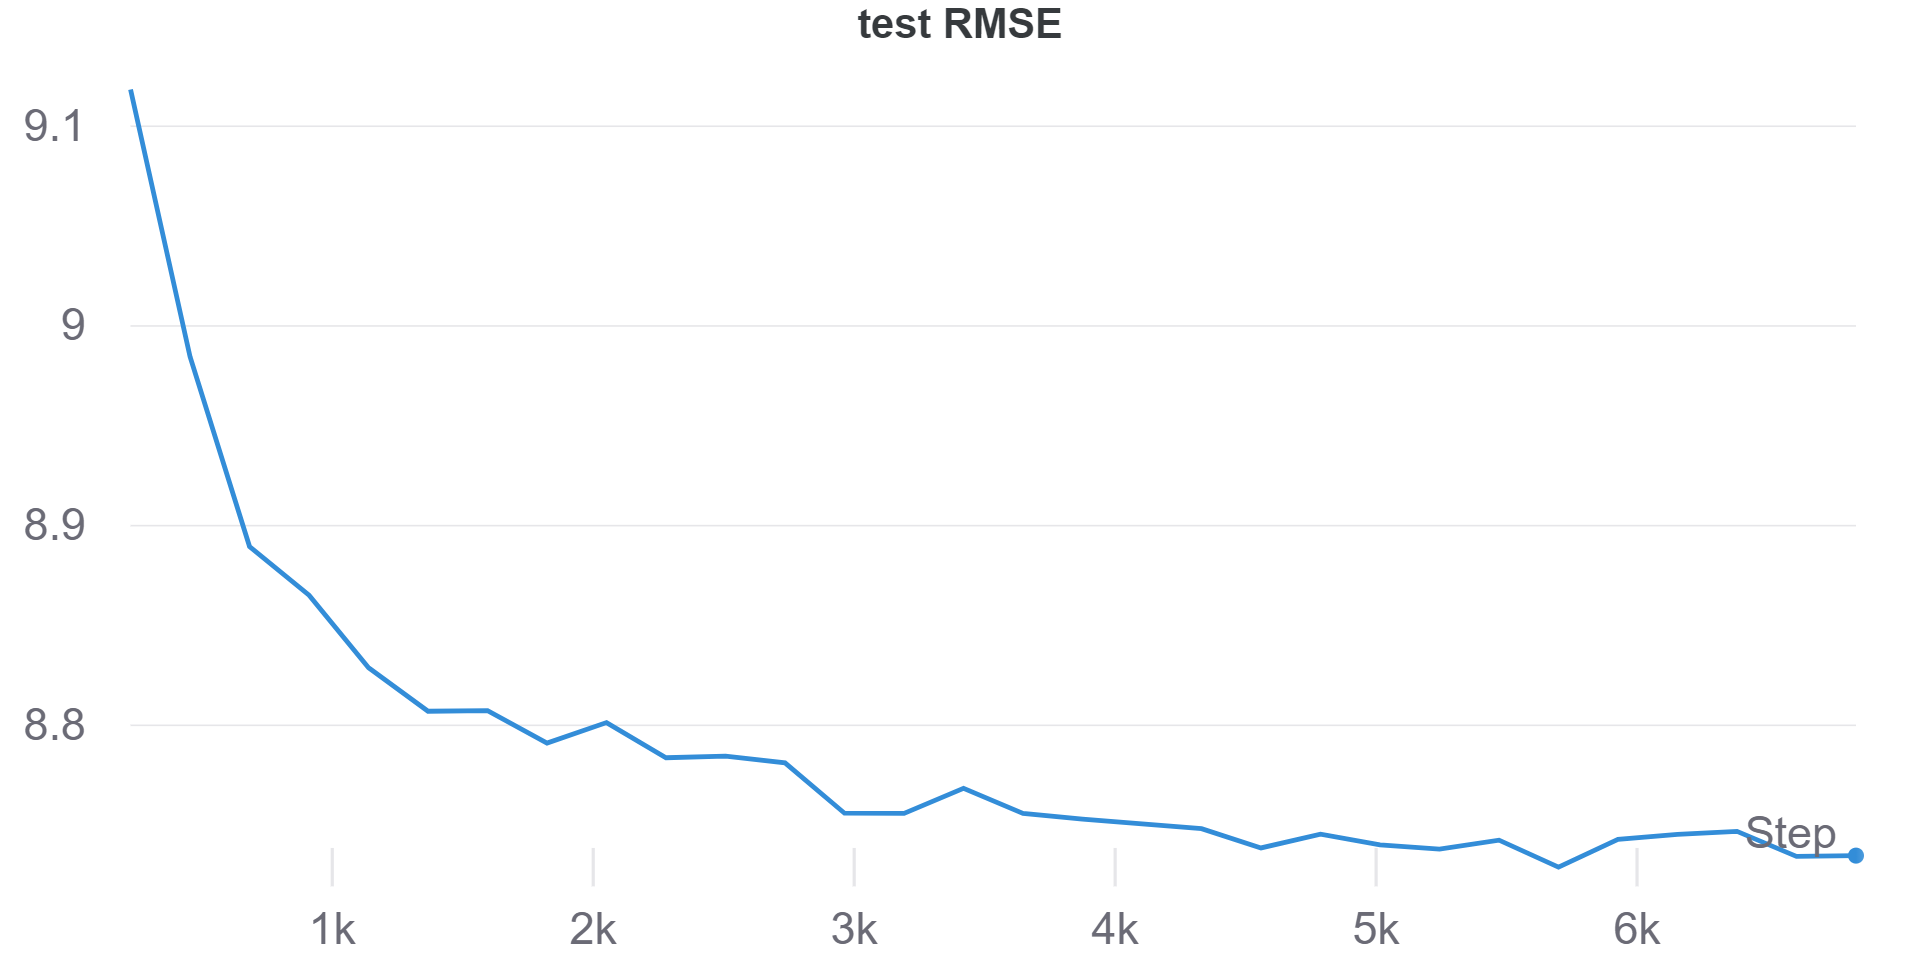

Посчитаю итоговую ошибку на тесте:

In [ ]:
predictions = test(model, test_loader, device)
print(mean_squared_error(torch.tensor(y_test_ss), predictions, squared=False) * y_scale[0])

8.734758034428168


С помощью Dropout слоя удалось избежать переобучения. Ошибка на тренировочной выборке после 20-й эпохи стабилизироалась и колебалась в районе 8.73 - 8.74, в итоге получаем ошибку 8.7348 и желаемое качество достигнуто!

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Свои рассуждения по ходу работы я приводила выше, во время выполнения самой работы, ниже опишу чуть подробнее ход своих мыслей:

1)
В качестве оптимизатора я выбрала Adam, потому что на четвёртом семинаре нам показали, что он быстрее сходится и в целом более стабильный, меньше нужно возиться с подбором гиперпараметров.

Learning Rate взяла так же рекомендованный на семинаре, сначала (для самой первой линейной модели) брала lr=0.001, для всех последующих брала lr=0.0005.
Вообще, проведённых экспериментов было, конечно, больше чем 4 и я пробовала обучать все эти модели с lr=0.001, но ошибка была более стабильно с lr=0.0005, поэтому в итоге я остановилась на нём, но увеличила колличество эпох (до этого я пробовала обучаться на 15 - 20 эпохах).

По поводу количества эпох. Кажется, что 30 - это даже с запасом и почти все представленные модели выходили на плато раньше 30 эпох. Но всё-таки решила остановиться на 30, чтобы лучше видель тенденцию ошибок на тренировочной и тестовой выборках. Так как модели простые и обучаются не так уж и долго, то колличество эпох не притично, поэтому смело взяла с запасом.



2)
Данные я предварительно шкалировала с использованием StandardScaler из sklearn, параметры для обратного шкалирования передавала в функцию train для корректного расчёта ошибок во время обучения и вывода RMSE на график в уже возвращённом в прежее состояние масштабе.

3)
Для работы использовала GPU, предоставляемое Google Colab, для более быстрого обучения. В функцию train в качестве аргумента device передавала собственно device на котором ведутся расчёты.

4)
В целом, моя стратегий решения была следующей:

Взять сначала самую элементарнейшую модель, потом учложнять, добавляя в неё слои и регуляризаторы. Так я и сделала, все ключевые эксперименты приведены.

5)
Отслеживала процесс обучения я с помощью wandb. Сведения об основных 4-х запусках хранятся в проекте с название "homework_1" в моём профиле на сайте: https://wandb.ai/polina_cherepanova. Проект острытый и можно помотреть всё прямо на сайте в интерактивном режиме. Кроме того, выше я прикрепляла все картинки отдельно после обучения каждой новой модели.